In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import scipy.special as sp
import itertools
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

In [146]:
data_plot=pd.read_csv('prostate.data', sep='\t')
data_plot.drop(columns=data_plot.columns[0], inplace=True)

train=pd.Series(data_plot.loc[:,'train'])
data_plot.drop(columns='train', inplace=True)

lpsa=pd.Series(data_plot.loc[:,'lpsa'])
predictors=pd.DataFrame(data_plot.drop(columns='lpsa'))

# Selezionare i dati di training e testing
dataTrain = data_plot.loc[train == 'T'].reset_index(drop=True) #necessario resettare indici
dataTest = data_plot.loc[train == 'F'].reset_index(drop=True)

# Selezionare la serie 'lpsa' dai dati di training e testing
lpsaTrain = pd.Series(dataTrain['lpsa'])
lpsaTest = pd.Series(dataTest['lpsa'])

predictorsTrain=pd.DataFrame(dataTrain.drop(columns='lpsa'))
predictorsTest=pd.DataFrame(dataTest.drop(columns='lpsa'))

scaler = StandardScaler()
predictorsTrain_std = pd.DataFrame(scaler.fit_transform(predictorsTrain), columns=predictorsTrain.columns)
predictorsTest_std = pd.DataFrame(scaler.transform(predictorsTest), columns=predictorsTrain.columns)

data_train=sm.add_constant(predictorsTrain_std)
data_test=sm.add_constant(predictorsTest_std)

In [147]:
# Inizializzare il modello di regressione Ridge con alpha=1.0
ridge_model = Ridge(alpha=1.0)

ridge_model.fit(predictorsTrain_std, lpsaTrain)

lpsa_pred_train = ridge_model.predict(predictorsTrain_std)
lpsa_pred_test = ridge_model.predict(predictorsTest_std)

# Valutare le prestazioni del modello
mse_train = mean_squared_error(lpsaTrain, lpsa_pred_train)
r2_train = r2_score(lpsaTrain, lpsa_pred_train)

mse_test = mean_squared_error(lpsaTest, lpsa_pred_test)
r2_test = r2_score(lpsaTest, lpsa_pred_test)

print(f"Mean Squared Error (Train): {mse_train}")
print(f"R^2 Score (Train): {r2_train}")
print(f"Mean Squared Error (Test): {mse_test}")
print(f"R^2 Score (Test): {r2_test}")

# Mostrare i coefficienti del modello e l'intercetta
coefficients = pd.Series(ridge_model.coef_, index=predictorsTrain.columns)
print("Coefficients:\n", coefficients)
print("Intercept:", ridge_model.intercept_)
print(predictorsTrain.columns)

Mean Squared Error (Train): 0.4397098588157029
R^2 Score (Train): 0.6940162194792774
Mean Squared Error (Test): 0.5125174233583769
R^2 Score (Test): 0.5117222864471653
Coefficients:
 lcavol     0.685410
lweight    0.289595
age       -0.134306
lbph       0.208411
svi        0.301625
lcp       -0.254532
gleason   -0.011252
pgg45      0.255985
dtype: float64
Intercept: 2.4523450850746262
Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'], dtype='object')


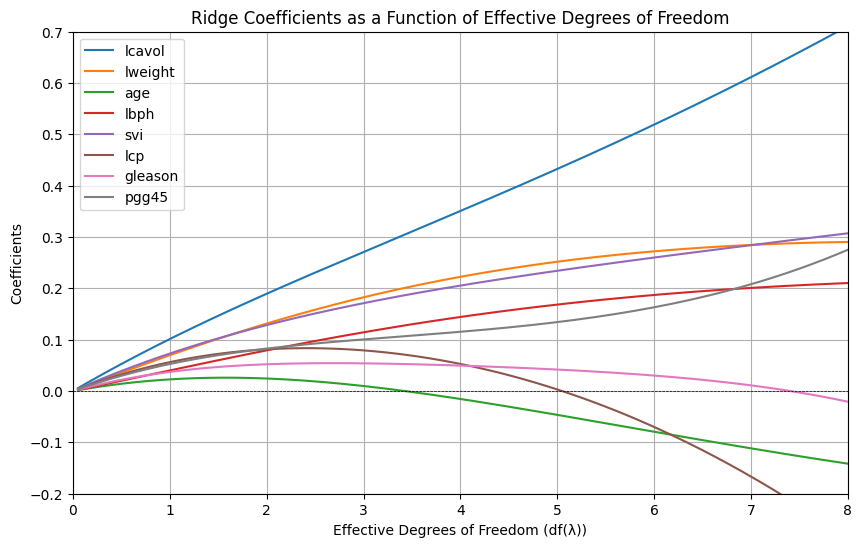

In [148]:
# Generare un vettore di parametri di regolarizzazione da 10^(-2) a 10^4 con 200 passi
alphas = np.logspace(-2, 4, 200)
msewo = []
r2wo = []
coefficients_list = []
df_lambda = []
a = []
c=100000.0

# Calcolare il modello di Ridge per ciascun valore di alpha e memorizzare i coefficienti e df(lambda)
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(predictorsTrain_std, lpsaTrain)
    coefficients_list.append(ridge_model.coef_)
    
    if mean_squared_error(lpsaTest,y) < c:
        c=mean_squared_error(lpsaTest,y)
        sa=alpha

    y=ridge_model.predict(predictorsTest_std)
    a.append(alpha)
    msewo.append(mean_squared_error(lpsaTest,y))
    r2wo.append(r2_score(lpsaTest,y))

    #print(r2wo,msewo)

    # Calcolare i gradi di libertà effettivi
    X = predictorsTrain_std.values
    I = np.identity(X.shape[1])
    H = X @ np.linalg.inv(X.T @ X + alpha * I) @ X.T
    df_lambda.append(np.trace(H))

coefficients_array = np.array(coefficients_list)


plt.figure(figsize=(10, 6))
for i, column in enumerate(predictorsTrain.columns):
    plt.plot(df_lambda, coefficients_array[:, i], label=column)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  
plt.xlim(0, 8)  
plt.ylim(-0.2, 0.7)  
plt.xlabel('Effective Degrees of Freedom (df(λ))')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as a Function of Effective Degrees of Freedom')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [149]:
print('PARAMETRI MIGLIORI SUL TESTSET')
print(f'Miglior alpha = {sa}\nMSE del miglior alpha = {c} ')

PARAMETRI MIGLIORI SUL TESTSET
Miglior alpha = 12.75051240713013
MSE del miglior alpha = 0.4872776437179069 


In [150]:
best_ridge = Ridge(alpha=sa)
best_ridge.fit(predictorsTrain_std,lpsaTrain)

# Predire i valori del modello
predictions_tr = best_ridge.predict(predictorsTrain_std)
predictions = best_ridge.predict(predictorsTest_std)
# Calcolare le prestazioni del modello
mse_tr = mean_squared_error(lpsaTrain,predictions_tr)
r2_tr = r2_score(lpsaTrain, predictions_tr)
# Calcolare le prestazioni del modello
mse = mean_squared_error(lpsaTest, predictions)
r2 = r2_score(lpsaTest, predictions)

print("Coefficients of the best model:")
print(best_ridge.coef_,'\n')

print("Performance of the best model on train:")
print(f"Mean Squared Error: {mse_tr}")
print(f"R^2 Score: {r2_tr}\n")

print("Performance of the best model on test:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Coefficients of the best model:
[ 0.50972376  0.270491   -0.07581147  0.18548697  0.2574937  -0.06120345
  0.03170498  0.15954962] 

Performance of the best model on train:
Mean Squared Error: 0.46984900276742314
R^2 Score: 0.6730430958999152

Performance of the best model on test:
Mean Squared Error: 0.48728686985874947
R^2 Score: 0.5357595511585664


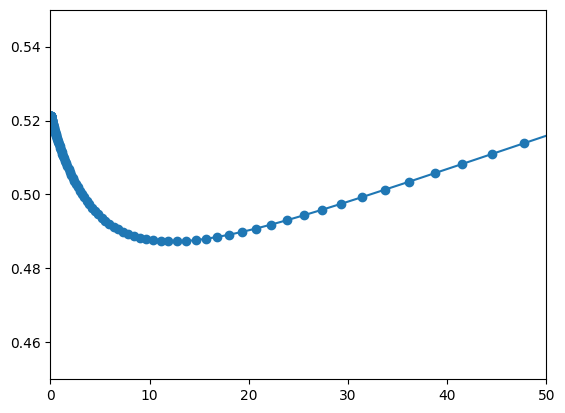

In [151]:
m=np.array(msewo)
plt.plot(a,m, marker='o')
plt.xlim(0,50)
plt.ylim(0.45,0.55)
plt.show()

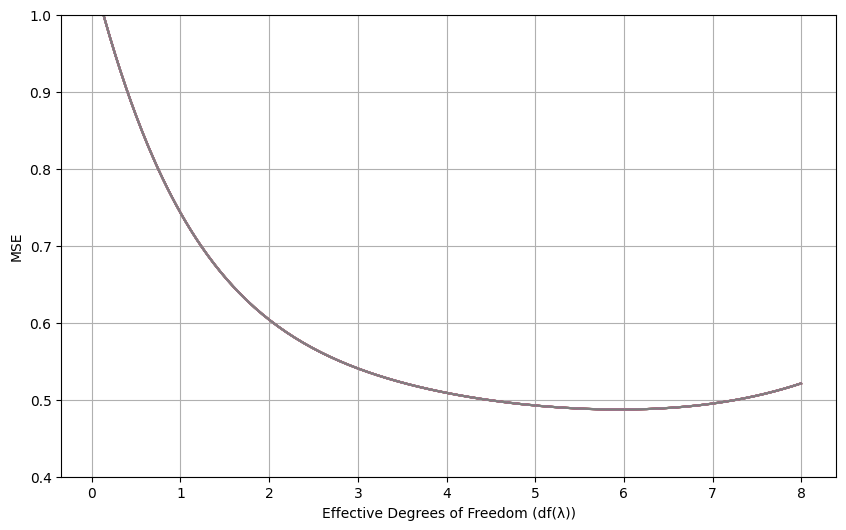

In [152]:
plt.figure(figsize=(10, 6))
for i, column in enumerate(predictorsTrain.columns):
    plt.plot(df_lambda, m, label=column)

plt.ylim(0.4,1.0)
plt.xlabel('Effective Degrees of Freedom (df(λ))')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

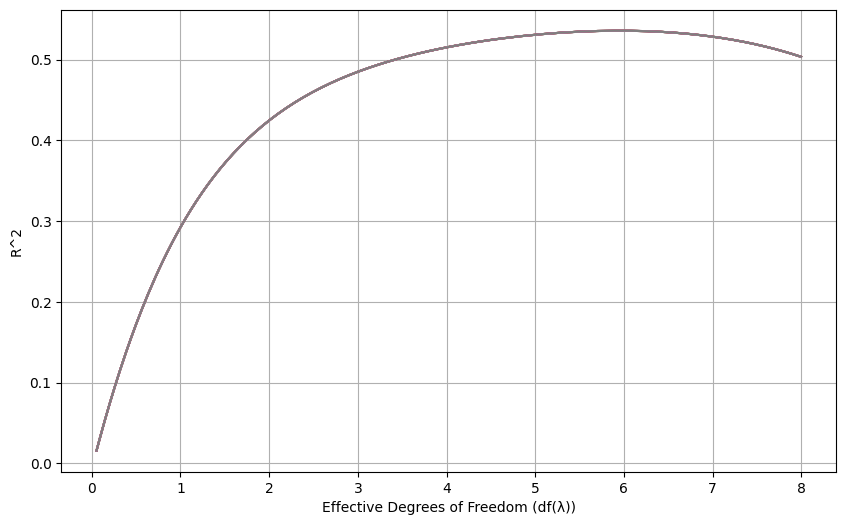

In [153]:
n=np.array(r2wo)
n.min()

plt.figure(figsize=(10, 6))
for i, column in enumerate(predictorsTrain.columns):
    plt.plot(df_lambda, n, label=column)

plt.xlabel('Effective Degrees of Freedom (df(λ))')
plt.ylabel('R^2')
plt.grid(True)
plt.show()

## RIDGE CON CROSSVALIDAZIONE E DATASET UNITO

In [154]:
# Unire i dati di addestramento e test
predictors_all = pd.concat([predictorsTrain_std, predictorsTest_std], axis=0)
lpsa_all = pd.concat([lpsaTrain, lpsaTest], axis=0)

# Inizializzare il modello RidgeCV utilizzando gli alphas generati in precedenza
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(predictors_all, lpsa_all)

# Calcolare la media per colonna dei cv_values_ per ottenere l'errore medio di cross-validazione per ciascun alpha
average_cv_error = np.mean(ridge_cv.cv_values_, axis=0)

# Trovare l'indice del minimo errore medio di cross-validazione
best_alpha_index = np.argmin(average_cv_error)
best_alpha = alphas[best_alpha_index]

print(f"Best alpha: {best_alpha}")
print(f"MSE medio migliore di cross-validazione: {average_cv_error.min()}")

#import sys 
#np.set_printoptions(threshold=sys.maxsize)
#print(ridge_cv.cv_values_.shape)


Best alpha: 5.170920242896756
MSE medio migliore di cross-validazione: 0.5366016119238796


In [155]:
# Addestrare un modello Ridge con l'alpha ottimale
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(predictors_all, lpsa_all)

# Predire i valori del modello
predictions = best_ridge.predict(predictors_all)

# Calcolare le prestazioni del modello
mse = mean_squared_error(lpsa_all, predictions)
r2 = r2_score(lpsa_all, predictions)

print("Coefficients of the best model:")
print(best_ridge.coef_)

print("Performance of the best model:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Coefficients of the best model:
[ 0.62229977  0.28490332 -0.13099073  0.12939872  0.29379199 -0.07161276
  0.04409166  0.10322093]
Performance of the best model:
Mean Squared Error: 0.44753808790401245
R^2 Score: 0.6606317305601164


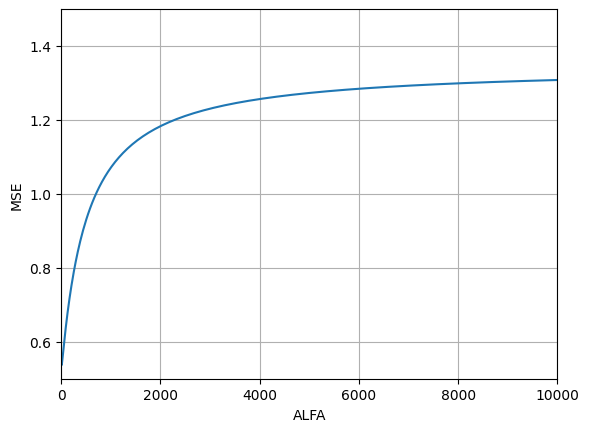

In [156]:
plt.plot(alphas,average_cv_error)
plt.ylim(0.5, 1.5)  
plt.xlim(0.0, 10000) 
plt.ylabel("MSE")
plt.xlabel("ALFA")
plt.grid(True)
plt.show()

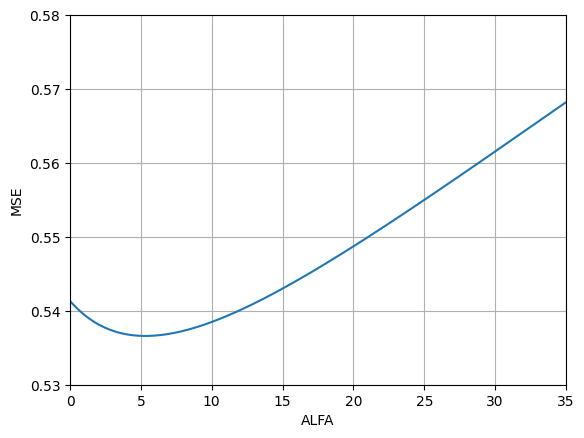

In [157]:
plt.plot(alphas,average_cv_error)

plt.ylim(0.53, 0.58)  
plt.xlim(0.0, 35)  
plt.ylabel("MSE")
plt.xlabel("ALFA")
plt.grid(True)
plt.show()

## RIDGE CON CV=10 FOLD

In [158]:
ridge_cv_mse = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=10)

ridge_cv_mse.fit(predictors, lpsa)

print(f"Miglior alpha (MSE): {ridge_cv_mse.alpha_}")

predictions_mse = ridge_cv_mse.predict(predictors)
mse_mse = mean_squared_error(lpsa, predictions_mse)
print(f"MSE del miglior modello: {mse_mse}")

Miglior alpha (MSE): 1.4820207057988586
MSE del miglior modello: 0.44549966426733884


In [159]:
# Lista per memorizzare gli MSE medi per ciascun alpha
mean_cv_errors = []

# Calcolare l'MSE per ciascun alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # Utilizzare cross_val_score con scoring='neg_mean_squared_error'
    scores = cross_val_score(ridge, predictors, lpsa, scoring='neg_mean_squared_error', cv=10)
    # Poiché i valori sono negativi, li rendiamo positivi e calcoliamo la media
    mean_cv_errors.append(-np.mean(scores))

# Trova il miglior alpha
best_alpha_index = np.argmin(mean_cv_errors)
best_alpha = alphas[best_alpha_index]

print(f"Miglior alpha (MSE): {best_alpha}")

# Stampa l'MSE medio per ciascun alpha
#for alpha, mse in zip(alphas, mean_cv_errors):
    #print(f"Alpha: {alpha:.5f}, Mean CV MSE: {mse:.5f}")

# Addestrare il modello finale con il miglior alpha
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(predictors, lpsa)

# Predire i valori del modello
predictions = best_ridge.predict(predictors)

# Calcolare le prestazioni del modello
mse = mean_squared_error(lpsa, predictions)
r2 = r2_score(lpsa, predictions)

print("Coefficients of the best model:")
print(best_ridge.coef_)

print("Performance of the best model:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Miglior alpha (MSE): 1.4820207057988586
Coefficients of the best model:
[ 0.5630655   0.56681466 -0.01998744  0.09875714  0.65436139 -0.08006597
  0.0355343   0.00464137]
Performance of the best model:
Mean Squared Error: 0.44549966426733884
R^2 Score: 0.6621774678295477


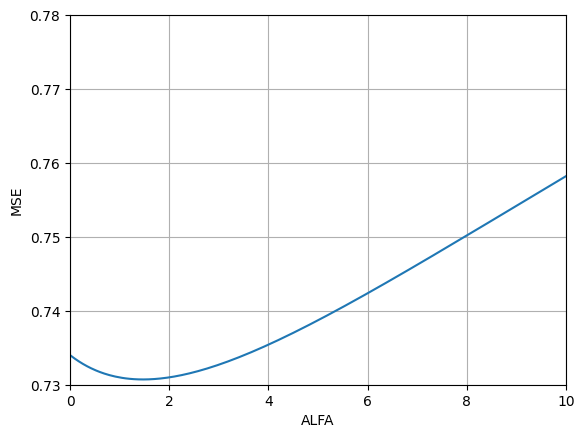

In [160]:
plt.plot(alphas,mean_cv_errors)

plt.ylim(0.73, 0.78)  
plt.xlim(0.0, 10)  
plt.ylabel("MSE")
plt.xlabel("ALFA")
plt.grid(True)
plt.show()

In [161]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path

## LASSO CON ALFA=0.1

In [162]:
lasso_cv = Lasso(alpha=0.1 )
lasso_cv.fit(predictorsTrain_std, lpsaTrain)

# Stampa i coefficienti del modello
print("Coefficients:\n", lasso_cv.coef_)

# Stampa l'intercetta del modello
print("Intercept:", lasso_cv.intercept_)

# Calcola il punteggio R^2 sul set di training
train_score = lasso_cv.score(predictorsTrain_std, lpsaTrain)
print("Training set score (R^2):", train_score)

# Calcola il punteggio R^2 sul set di test
test_score = lasso_cv.score(predictorsTest_std, lpsaTest)
print("Test set score (R^2):", test_score)

Coefficients:
 [ 0.57065706  0.22862578 -0.          0.10501276  0.17097605  0.
  0.          0.06532039]
Intercept: 2.4523450850746262
Training set score (R^2): 0.6477995461225832
Test set score (R^2): 0.568790166425063


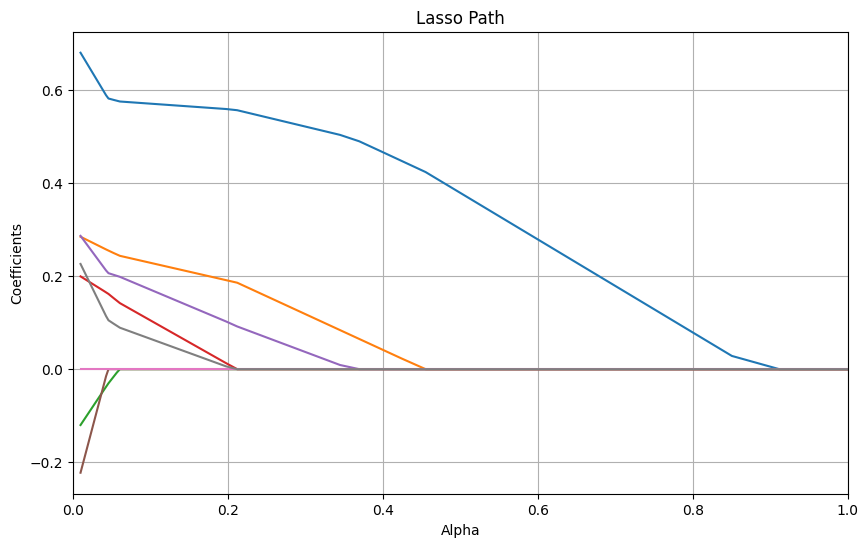

In [163]:
alphas_lasso, coefs_lasso, _ = lasso_path(predictorsTrain_std, lpsaTrain, alphas=alphas)

# Traccia i coefficienti in funzione di alpha
plt.figure(figsize=(10, 6))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i])

plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Path')

plt.xlim(0,1.0)
plt.show()

# LASSO CON CROSS VALIDAZIONE

In [164]:
# Utilizza LassoCV per trovare il miglior parametro alpha
lasso_cv = LassoCV(alphas=alphas, cv=10)  # Cambia il valore di cv per testare diversi numero di fold
lasso_cv.fit(predictorsTrain_std, lpsaTrain)

# Stampa il miglior parametro alpha trovato
print("Best alpha (lambda):", lasso_cv.alpha_)

# Stampa i coefficienti del modello
print("Coefficients:\n", lasso_cv.coef_)

# Stampa l'intercetta del modello
print("Intercept:", lasso_cv.intercept_)

# Calcola il punteggio R^2 sul set di training
train_score = lasso_cv.score(predictorsTrain_std, lpsaTrain)
print("Training set score (R^2):", train_score)

# Calcola il punteggio R^2 sul set di test
test_score = lasso_cv.score(predictorsTest_std, lpsaTest)
print("Test set score (R^2):", test_score)

# Calcola l'errore quadratico medio sul set di test
test_mse = mean_squared_error(lpsaTest, lasso_cv.predict(predictorsTest_std))
print("Test set MSE:", test_mse)

Best alpha (lambda): 0.01
Coefficients:
 [ 0.68014784  0.28463908 -0.12007823  0.19937268  0.28658522 -0.22266278
 -0.          0.22612368]
Intercept: 2.4523450850746262
Training set score (R^2): 0.6929302449549175
Test set score (R^2): 0.5248719054252093
Test set MSE: 0.49871501409473484
